## **Installs**

In [1]:
!pip install simfin

     |████████████████████████████████| 60 kB 2.9 MB/s 


# **Imports**

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# Scikit-learn imports.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [3]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

## **SimFin Config**

In [4]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [5]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [6]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## **Data Hub**

In [7]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [8]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 10 µs, sys: 5 µs, total: 15 µs
Wall time: 17.9 µs


## **Signals**

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' not on disk.
- Running function fin_signals() ... 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done!
- Saving cache-file to disk ... Done!
CPU times: user 3min 3s, sys: 14.1 s, total: 3min 17s
Wall time: 3min 30s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [10]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 1min 38s, sys: 7.03 s, total: 1min 45s
Wall time: 1min 55s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [11]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 2min 28s, sys: 4.89 s, total: 2min 32s
Wall time: 2min 31s


We now combine all the signals into a single DataFrame:

In [67]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 6.05 s, sys: 2.59 s, total: 8.64 s
Wall time: 8.6 s


In [13]:
df_signals.dropna(how='all').tail()

(Dividends + Share Buyback) / FCF  ...  Price to Book Value
Ticker Date                                           ...                     
ZYXI   2020-07-28                          -0.091642  ...            27.067540
       2020-07-29                          -0.091642  ...            26.804322
       2020-07-30                          -0.091642  ...            27.593975
       2020-07-31                          -0.091642  ...            27.959555
       2020-08-03                          -0.091642  ...            27.623221

[5 rows x 42 columns]

## **Missing Data**

Some of the signals have a lot of missing data which cannot be handled by scikit-learn. Let us first see the fraction of each signal-column that is missing:

In [14]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

R&D / Revenue                        0.608676
R&D / Gross Profit                   0.608537
Return on Research Capital           0.608537
Dividend Yield                       0.442309
Inventory Turnover                   0.286428
Debt Ratio                           0.262356
Net Acquisitions / Total Assets      0.261853
Sales Growth YOY                     0.166980
FCF Growth YOY                       0.157142
Assets Growth YOY                    0.157127
Earnings Growth YOY                  0.157127
Sales Growth                         0.145817
FCF Growth                           0.137345
Assets Growth                        0.137345
Earnings Growth                      0.137345
Interest Coverage                    0.100301
Sales Growth QOQ                     0.076337
FCF Growth QOQ                       0.063977
Earnings Growth QOQ                  0.063977
Assets Growth QOQ                    0.063977
CapEx / (Depr + Amor)                0.039962
P/Sales                           

We then remove all signals that have more than 25% missing data:

In [15]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital'],
      dtype='object')

## **1-3 Year Returns**

We want to try and predict the average 1-3 year returns. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [16]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [17]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 58.6 s, sys: 1.44 s, total: 1min
Wall time: 58.8 s


In [18]:
df_returns_1_3y

Ticker  Date      
A       2007-01-03   -0.147205
        2007-01-04   -0.149268
        2007-01-05   -0.144580
        2007-01-08   -0.143036
        2007-01-09   -0.144187
                        ...   
ZYXI    2020-07-28         NaN
        2020-07-29         NaN
        2020-07-30         NaN
        2020-07-31         NaN
        2020-08-03         NaN
Name: Total Return 1-3 Years, Length: 6945848, dtype: float64

## **Combine Signals and Returns**

We then combine the signals and returns into a single DataFrame to align the data.

In [19]:
%%time
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

CPU times: user 1.93 s, sys: 15.3 ms, total: 1.94 s
Wall time: 1.93 s


In [20]:
df_sig_rets.shape

(6945848, 36)

## **Data Cleaning**

The data also contains outliers and still has missing values, so let us fix that now. A common method for removing outliers is so-called Winsorization of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize both the stock-returns and all the signals. After that, we will remove all rows with missing values, because scikit-learn cannot handle that. Finally we remove tickers that have less than 200 rows of data.

There are more than 6 million data-rows before this cleaning:

In [21]:
%%time

# Clip the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because scikit-learn cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 21.6 s, sys: 4.75 s, total: 26.3 s
Wall time: 22.9 s


In [22]:
df_sig_rets.shape

(1706396, 36)

The reason that so many rows have been removed, is that scikit-learn cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway. 

## **Correlation: Signals vs. Return**

Linear correlation (aka. Pearson correlation) is a simple statistical measure of how two variables change together. The linear correlation between the signals and stock-returns can be used to assess which signals might be the best predictors for stock-returns.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation (see examples here).

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

The following calculates the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [23]:
# New column-name for correlation between signals and returns.
RETURN_CORR = 'Return Correlation'

# Calculate the correlation between all data-columns.
df_corr = df_sig_rets.corr()

# Correlation between signals and returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y] \
                    .abs() \
                    .drop(TOTAL_RETURN_1_3Y) \
                    .sort_values(ascending=False) \
                    .rename(RETURN_CORR)

# Show the correlations between signals and returns.
df_corr_returns

Net Profit Margin                    0.180413
Return on Assets                     0.167867
Earnings Yield                       0.150990
Log Revenue                          0.131642
Return on Equity                     0.122219
FCF Yield                            0.117659
P/E                                  0.073909
P/FCF                                0.063388
P/Sales                              0.061844
Current Ratio                        0.060161
Market-Cap                           0.058252
Dividends / FCF                      0.048962
CapEx / (Depr + Amor)                0.041523
Quick Ratio                          0.040606
Price to Book Value                  0.033884
(Dividends + Share Buyback) / FCF    0.031616
P/NCAV                               0.031360
Asset Turnover                       0.029806
P/NetNet                             0.027302
FCF Growth                           0.027016
Assets Growth QOQ                    0.024992
Assets Growth                     

## **Split Training / Test-Sets**

When training a Machine Learning model, we typically split the dataset into training- and test-sets. Only the training-set is used to train the model, after which the model is used on the test-set, to assess how the model performs on data it has not seen during training.

If we randomly divide all the data-rows into training- and test-sets, we would most likely get data for every stock-ticker in both the training- and test-sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock-tickers, so a ticker belongs to either the training- or test-set, but not both. We use 80% of all the tickers in the training-set, and 20% in the test-set.

In [24]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

Now that we have lists of tickers for the training- and test-sets, we can select those rows from the DataFrame with signals and stock-returns:

In [25]:
%%time
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

CPU times: user 218 ms, sys: 78.6 ms, total: 297 ms
Wall time: 292 ms


We can then split these DataFrames into signals and stock-returns; that is, X and y-values that the Machine Learning model must try and find a mapping between. In scikit-learn's notation, the capital X indicates a 2-dimensional array or matrix, and the lower-case y indicates a 1-dimensional array.

In [26]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with stock-returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

In [27]:
X_train.shape, y_train.shape

((1368688, 35), (1368688,))

In [28]:

X_test.shape, y_test.shape

((337708, 35), (337708,))

## **Helper Functions**

The following are helper-functions for printing and plotting the results.

In [29]:
# List of signal names.
signal_names = X_train.columns.values

# List of signal names where spaces are replaced with _
signal_names_ = [s.replace(' ', '_') for s in signal_names]

In [30]:
# Column-name.
FEATURE_IMPORTANCE = 'Feature Importance'

In [31]:
def compare_feature_imp_corr(estimator):
    """
    Return a DataFrame which compares the signals' Feature
    Importance in the Machine Learning model, to the absolute
    correlation of the signals and stock-returns.
    
    :param estimator: Sklearn ensemble estimator.
    :return: Pandas DataFrame.
    """
    
    # Wrap the list of Feature Importance in a Pandas Series.
    df_feat_imp = pd.Series(estimator.feature_importances_,
                            index=signal_names,
                            name=FEATURE_IMPORTANCE)

    # Concatenate the DataFrames with Feature Importance
    # and Return Correlation.
    dfs = [df_feat_imp, df_corr_returns]
    df_compare = pd.concat(dfs, axis=1, sort=True)
    
    # Sort by Feature Importance.
    df_compare.sort_values(by=FEATURE_IMPORTANCE,
                           ascending=False, inplace=True)
    
    return df_compare

In [32]:
def print_tree(estimator, max_depth=6, **kwargs):
    """
    Print the first Decision Tree from a Random Forest.
    :param estimator: Sklearn ensemble estimator.
    """
    s = export_text(estimator.estimators_[0],
                    max_depth=max_depth,
                    feature_names=signal_names_,
                    **kwargs)
    print(s)

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [1.0, -1.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

## **Machine Learning: Regression**

Now that the data has been prepared, we can create a Machine Learning model using scikit-learn. Because we want to map financial signals x to stock-returns y that are continuous values, we need to use a so-called Regression model. In this example, we will use a Random Forest which is an ensemble of many Decision Trees, because it computes fairly quickly. An example of a Decision Tree will be shown further below, once the model has been fitted to the training-data.

The model has many parameters that adjust its ability to fit the training-data, possibly at the cost of having a worse fit on the test-data. This is the usual dilemma between over- and under-fitting the model to the training-data. If we overfit the model, it means that it has learned to recognize noise in the training-data which does not generalize to the test-set. Conversely, if we underfit the model, it means that it has not learned some essential features in the training-data that also generalize to the test-data.


In [34]:
# Parameters for scikit-learn's Random Forest models.
model_args = \
{
    # Random Forest parameters to adjust between
    # over- and under-fitting.
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 100,
    'min_samples_leaf': 10,

    # Use all available CPU cores.
    'n_jobs': -1,

    # Set random seed to make the experiments repeatable.
    'random_state': 1234,
}

In [35]:
# Create the estimator, but don't do any computations yet.
regr = RandomForestRegressor(**model_args)

In [36]:
%%time
# Fit the estimator to the training-data.
# This may take several minutes on a 4-core CPU.
_ = regr.fit(X=X_train, y=y_train)

CPU times: user 1h 26min 15s, sys: 2.66 s, total: 1h 26min 17s
Wall time: 21min 49s


Now that the Random Forest model has been fitted to the training-data, we can show one of the 100 Decision Trees that it found. These are deeply nested if-then-else statements on the signals, which result in some output value. The output of 100 such Decision Trees are averaged to create the output of the entire ensemble known as a Random Forest.

Clearly, the model does not contain any profound insight. It does not understand anything about finance. The model has just found that it could estimate the mapping between signals x and stock-returns y in the training-data, using many of these finely tuned if-then-else statements.

In [37]:
print_tree(regr)

|--- Net_Profit_Margin <= -0.69
|   |--- P/FCF <= -1.59
|   |   |--- P/NCAV <= 0.72
|   |   |   |--- P/Cash <= 3.13
|   |   |   |   |--- Log_Revenue <= 7.15
|   |   |   |   |   |--- Gross_Profit_Margin <= 0.95
|   |   |   |   |   |   |--- P/NCAV <= -16.38
|   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |--- P/NCAV >  -16.38
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- Gross_Profit_Margin >  0.95
|   |   |   |   |   |   |--- Return_on_Assets <= -0.40
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- Return_on_Assets >  -0.40
|   |   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |--- Log_Revenue >  7.15
|   |   |   |   |   |--- CapEx_/_(Depr_+_Amor) <= 1.81
|   |   |   |   |   |   |--- FCF_Yield <= -0.01
|   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |--- FCF_Yield >  -0.01
|   |   |   |   |   |   |   |--- value: [-0.17]
|   

We can also show the mutual importance of the signals (aka. features) in the model, and compare it to their correlation with the stock-returns. These are often quite different. The signals with highest correlations to the future stock-returns, are not necessarily the ones that were most important to the model. But remember that correlation only measures the linear relation between signals and stock-returns, while the Random Forest can find complicated non-linear relations.

In [38]:
compare_feature_imp_corr(regr)

,Feature Importance,Return Correlation
Net Profit Margin,0.062059,0.180413
Log Revenue,0.061262,0.131642
Gross Profit Margin,0.058579,0.011243
Asset Turnover,0.050048,0.029806
Market-Cap,0.049964,0.058252
CapEx / (Depr + Amor),0.045054,0.041523
Interest Coverage,0.038822,0.014208
P/NCAV,0.037763,0.031360
Current Ratio,0.036938,0.060161
Quick Ratio,0.034829,0.040606


## **Regression Results**
Let us now see how well the Machine Learning model performs. First we use the fitted model to predict the stock-returns for the training- and test-sets:

In [39]:
%%time
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

CPU times: user 20.7 s, sys: 255 ms, total: 21 s
Wall time: 5.95 s


We can then calculate the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.

As we can see, the $R^2$ value is quite high for the training-set, so the model has learned to map the signals X to stock-returns y quite well for the training-set:

In [40]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.9434606448336921

But the $R^2$ value is very bad for the test-set, so the model has not really learned the underlying relation between the signals X and stock-returns y. The model has merely learned noise or peculiarities in the training-data, which do not generalize to the unseen data in the test-set:

In [41]:
r2_score(y_true=y_test, y_pred=y_test_pred)

-0.12705535141049906

## **Regression Examples**

We can also try and plot the model's predicted versus actual stock-returns for a stock in the training-set. As we can see, the model has learned this mapping quite well:

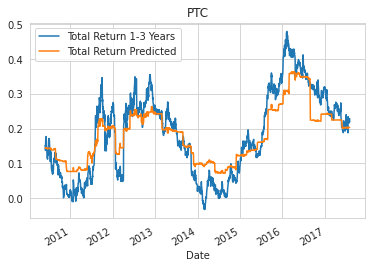

In [42]:
# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual stock-returns for the first stock in the test-set. As we can see, the model is completely unable to predict the stock-returns, for this data that it has not seen during its training:

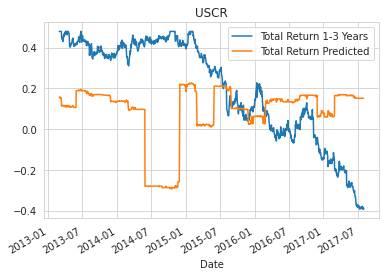

In [66]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test.loc[ticker].plot(title=ticker)

## **Machine Learning: Classification**

Instead of mapping from signals x to a continuous variable y for the stock-return, we can try and map to discrete output-classes that indicate if the stock-return was a gain or loss. This is a so-called binary classification problem, and perhaps that is easier for the Machine Learning model.

First we need to convert the stock-returns into values of either 1.0 for gains or -1.0 for losses, and then split into training- and test-sets:

In [44]:
%%time
# Convert stock-returns to binary classes by taking the sign.
df_cls = np.sign(df_sig_rets[TOTAL_RETURN_1_3Y])

# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 76.8 ms, sys: 7 ms, total: 83.8 ms
Wall time: 83.7 ms


The training-set is biased because it contains many more stocks with gains than losses:

In [45]:
# Fraction of the training-set that is classified as gains.
(y_train_cls == 1.0).sum() / len(y_train_cls)

0.701823936499772

We instruct the Machine Learning model to take this bias into account, by setting class_weight='balanced', and otherwise use the same arguments as above:

In [46]:
clf = RandomForestClassifier(class_weight='balanced', **model_args)

We can then fit the model to the training-data. This is much faster then for the regression model above, because we only have a binary class as output:

In [47]:
%%time
_ = clf.fit(X=X_train, y=y_train_cls)

CPU times: user 12min 26s, sys: 1.23 s, total: 12min 27s
Wall time: 3min 9s


As for the regression model above, the Random Forest consists of 100 Decision Trees, which are basically just nested if-then-else statements that split the input signals, to try and find a mapping that fits the input and output of the training-data.

In [48]:
print_tree(clf)

|--- Log_Revenue <= 8.13
|   |--- P/E <= -0.01
|   |   |--- P/Sales <= 4.98
|   |   |   |--- FCF_Yield <= -0.29
|   |   |   |   |--- P/E <= -3.26
|   |   |   |   |   |--- Current_Ratio <= 3.59
|   |   |   |   |   |   |--- Log_Revenue <= 7.61
|   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |--- Log_Revenue >  7.61
|   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- Current_Ratio >  3.59
|   |   |   |   |   |   |--- Earnings_Yield <= -0.16
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- Earnings_Yield >  -0.16
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- P/E >  -3.26
|   |   |   |   |   |--- FCF_Growth_YOY <= -1.16
|   |   |   |   |   |   |--- Log_Revenue <= 7.91
|   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |--- Log_Revenue >  7.91
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- F

We can also show the signals (or features) that the model found were most important. These are not necessarily the signals that are best correlated with stock-returns, because the Random Forest is a non-linear mapping from signals to the gain/loss classification.

In [49]:
compare_feature_imp_corr(clf)

,Feature Importance,Return Correlation
Log Revenue,0.047610,0.131642
Market-Cap,0.042871,0.058252
Gross Profit Margin,0.041422,0.011243
Asset Turnover,0.038098,0.029806
Net Profit Margin,0.036092,0.180413
Return on Assets,0.035309,0.167867
CapEx / (Depr + Amor),0.034205,0.041523
Interest Coverage,0.033821,0.014208
Quick Ratio,0.033063,0.040606
Current Ratio,0.032245,0.060161


## **Classification Results**

We can then use the fitted model to predict the classes for the training- and test-sets:

In [50]:
%%time
y_train_pred_cls = clf.predict(X_train)
y_test_pred_cls = clf.predict(X_test)

CPU times: user 26.3 s, sys: 267 ms, total: 26.5 s
Wall time: 7.14 s


The model has a very high classification accuracy on the training-set, so the model has learned to map financial signals to gain/loss classifications for 1-3 year investment periods:

In [51]:
accuracy_score(y_true=y_train_cls, y_pred=y_train_pred_cls)

0.9788607776206119

Unfortunately this performance does not generalize to the test-set, which the model has not seen during training. Here the classification accuracy is much lower:

In [52]:
accuracy_score(y_true=y_test_cls, y_pred=y_test_pred_cls)

0.6745117083397492

This is about the same score as simply guessing that the stock-returns are always gains:

In [53]:
# Fraction of the test-set that is classified as gains.
(y_test_cls == 1.0).sum() / len(y_test_cls)

0.6776919705781326

## **Confusion Matrix**
We can also plot a so-called Confusion Matrix, which shows how the classes were predicted. For the training-set, we again see that the model has learned to accurately classify gains and losses. Note how the colours are different, because the training-set contains many more gains than losses.

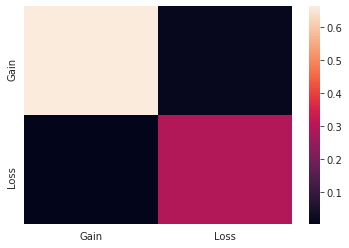

In [54]:
plot_confusion_matrix(y_true=y_train_cls, y_pred=y_train_pred_cls)

The confusion matrix for the test-set, shows that most classes were predicted as gains:

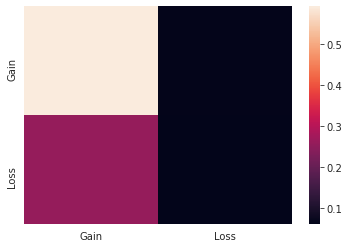

In [55]:
plot_confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cls, y_test_pred_cls))

              precision    recall  f1-score   support

        -1.0       0.49      0.19      0.28    108846
         1.0       0.70      0.90      0.79    228862

    accuracy                           0.67    337708
   macro avg       0.59      0.55      0.53    337708
weighted avg       0.63      0.67      0.62    337708



## **Classification Examples**
We can also try and plot the model's predicted versus actual gain/loss classification for a stock in the training-set. As we can see, the model has learned this mapping reasonably well:

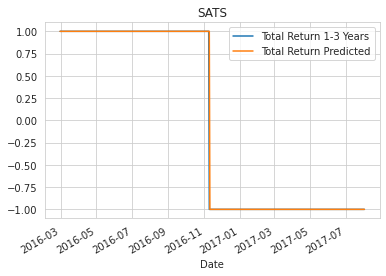

In [57]:
# Create a DataFrame with actual and predicted classifications.
# This is for the training-set.
df_y_train_cls = pd.DataFrame(y_train_cls)
df_y_train_cls[TOTAL_RETURN_PRED] = y_train_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[22]
_ = df_y_train_cls.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual gain/loss classifications for the first stock in the test-set. As we can see, the model is quite bad at predicting this for data that it has not seen during its training:

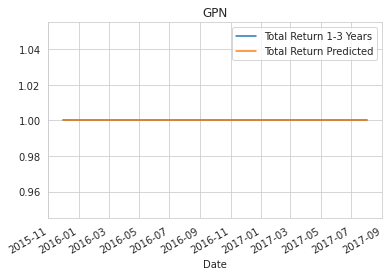

In [58]:
# Create a DataFrame with actual and predicted classifications.
# This is for the test-set.
df_y_test_cls = pd.DataFrame(y_test_cls)
df_y_test_cls[TOTAL_RETURN_PRED] = y_test_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[22]
_ = df_y_test_cls.loc[ticker].plot(title=ticker)